In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import folium
import pickle
from math import radians, sin, cos, sqrt, atan2
from geopy.geocoders import Nominatim
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Class that analyzes the house market in CPH. Returns the available options according to the given arguments.

In [74]:
class apartments_in_cph():
    def apartments(self,number_sites=10):
        def apartments_details(url):    
            # get access to the site
            response = requests.get(url)

            # Create a BeautifulSoup object and specify the parser
            soup = BeautifulSoup(response.text, "html.parser")
            block = soup.find_all('div',class_="css-ho2tek")


            # scrape boligportal site and get all the info of the apartments there        
            details = {'id':[],'location':[],'rooms':[],'type':[],'size':[],'time':[],'rent':[],'comments':[],'link':[]}
            times = ['hour','minutes','days','esterday','january','february','march','april','may','june','july','august','september','october','november','december']
            for i in block:
                blockII = i.find_all('div')
                if len(blockII) != 1:
                    for j in blockII:
                        blockIII = j.find_all('div')
                        for z in blockIII:
                            for a in blockIII:
                                blockIV = a.find_all('a',class_='AdCardSrp__Link css-17x8ssx')
                                if len(blockIV) != 0:
                                    for b in blockIV:
                                        bI = b
                                        link = 'https://www.boligportal.dk{}'.format(b.get("href"))
                                        id_ = b.get("href").split('id-')[1]    
                                        details['id'].append(id_)
                                        details['link'].append(link)                                                            


                                    details_ = bI.find_all('div',class_='css-js2eza')
                                    location = bI.find_all('div',class_='css-1w4wg57')
                                    comments = bI.find_all('div',class_='css-11zpaaj')
                                    time = bI.find_all('span',class_='css-745efe')
                                    price = bI.find_all('div',class_='css-1slo7p8')

                                    for l in details_:                                
                                        l = l.text.split()
                                        num_rooms = l[0]
                                        type_ = l[3]
                                        size = l[5]
                                        try:
                                            details['rooms'].append(num_rooms)
                                            details['type'].append(type_)
                                            details['size'].append(size)
                                        except:          
                                            # sometimes there are rooms and half (2.5). Pass it as a float instead of int                      
                                            num_rooms = num_rooms.replace(',','.')
                                            details['rooms'].append(num_rooms)
                                            details['type'].append(type_)
                                            details['size'].append(size)


                                    for l in location:
                                        details['location'].append(l.text)                                
                                    for l in comments:
                                        details['comments'].append(l.text)                        
                                    for l in time:
                                        details['time'].append(l.text)  
                                    
                                    for l in price:
                                        text = l.find('span')
                                        details['rent'].append(float(text.text.split()[0]))            

            # put all the lists into one big list
            detailsII = list(set(zip(details['id'],details['location'],details['rooms'],details['type'],details['size'],details['time'],details['rent'],details['comments'],details['link'])))
            dic = {k:[] for k in details} 
            for i in detailsII:
                for j in range(len(i)):
                    dic[list(dic.keys())[j]].append(i[j])
            
            
            # mkaing a df with all the gained info
            df = pd.DataFrame(dic)

            # add acolumn ratio where we see how much each person would have to pay
            arr = np.array([int(i) if i is isinstance(i,int) else float(i.replace(',','.')) for i in df.rooms])
            
            # if there are 2 rooms, treat it as if it were 1 room    
            arr[np.where(arr == 1)] = 2

            df['ratio (1000 DKK)/person'] = np.round(np.array([float(i) for i in df.rent])/np.array([i-1 for i in arr]),2)

            # add a column for at which site the said apartment was found
            if len(url.split('=')) >= 2:
                df['site_num'] = [url.split('=')[-1]]*df.shape[0]    
            else:
                df['site_num'] = ['main_site']*df.shape[0]    



            return df     

        all_apartments = []
        print('### Start ###')
        print('\tGoing through {} BoligPortal websites'.format(number_sites))
        for i in tqdm(range(number_sites)):
            sleep(0.00000000000000000000000000001)
            if i == 0:
                url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/"
            else: 
                url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/?offset={}".format(18*i)
            all_apartments.append(apartments_details(url))
        df = pd.concat(all_apartments,axis=0)
        df = df.drop_duplicates().reset_index(drop=True)

        print('### Done ###')
        return df

    def haversine_distance(self,coordinates):
        # function that finds he distance between two coordinates
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = coordinates
        lat1_rad = radians(lat1)
        lon1_rad = radians(lon1)
        lat2_rad = radians(lat2)
        lon2_rad = radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        radius = 6371  # Earth's radius in kilometers
        distance = radius * c

        return distance

    def coordinates(self,df):
        # here is where we are going to save the coordinates so that we do onthave to run the cell below all the time
        # Open/load the pickle file back into Python
        with open('coordinated.pickle', 'rb') as file:
        # with open('coordinated.pickle', 'rb') as file:
            loaded_coordinates = pickle.load(file)
        # print('\tNumber of known coordinates:{}'.format(len(loaded_coordinates)))

        # add a column for the coordinates of the different places
        # iterate thorugh every location and gets its coordinate. The ones where there is an error is because the library cannot identify said address
        def setting_coordinates(df,coordinates:dict):
            locations = set(list(df.location))

            for i in tqdm(locations):
                sleep(0.00000000000000000000000000001)
                if i not in list(coordinates.keys()):
                    # print(i,'Found in location:',np.where(np.array(list(coordinates.keys())) == i))
                    try:
                        coordinates[i] = loc.geocode(i).point[:2]
                    except: 
                        coordinates[i] = "Error"
            
            loc = Nominatim(user_agent="GetLoc")
            getLoc = loc.geocode("IT University of Copenhaguen")    
            # getLoc = loc.geocode("Nordhavn Station")

            # do this for the apartments and IT university
            df['Coordinates'] = [coordinates[i] for i in df.location]
            df['ITU_coordinates'] = [getLoc.point[:2]]*df.shape[0]

            # calculate the distance between each house and ITU
            distance = lambda i:round(self.haversine_distance(df.iloc[i].Coordinates+df.iloc[i].ITU_coordinates),2)
            distances = []

            for i in range(df.shape[0]):    
                try:
                    distances.append(float(distance(i)))
                except:
                    distances.append('Error')
            df['Distance (km)'] = distances

            # order the df based on the ratio
            df = df.sort_values('ratio (1000 DKK)/person')    
            
            # see if id is one of the columns and make sure that we do not repeat this column
            if 'id' not in list(df.columns):
                df = df.reset_index()
                df = df.rename(columns={'index': 'id'})
            else:
                df = df.reset_index(drop=True)

            return df,coordinates

        print('\n### Start ###')
        print('\tGetting the coordinates of addresses')
        df,coordinates = setting_coordinates(df,coordinates=loaded_coordinates)
        print('### Done ###')


        # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
        with open('coordinated.pickle', 'rb') as file:
        # with open('coordinated.pickle', 'rb') as file:
            loaded_coordinates = pickle.load(file)

        # Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
        if len(loaded_coordinates) < len(coordinates):
            print('\n### Saving new coordinates ###')
            with open('coordinated.pickle', 'wb') as file:
            # with open('coordinated.pickle', 'wb') as file:
                pickle.dump(coordinates, file)
            print('New pickled number of coordinates: {}'.format(len(coordinates)))
            print('Done')
        
        return df
        
    def shareable(self,df,n:int):
        # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
        with open('shareable_info.pickle', 'rb') as file:
        # with open('coordinated.pickle', 'rb') as file:
            shareable_info_pickled = pickle.load(file)

        # make a dictionary with all the required information for the url. All you must do i give the row index as an argument
        def url_arguments_dic(df,n=0):
            row = n
            url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
            if df.iloc[row].type == 'Apartment':
                url_dic['type'] = 'apartments'
            elif df.iloc[row].type == 'Room':
                url_dic['type'] = 'rooms'
            url_dic['size'] = df.iloc[row]['size']
            try:
                url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
            except:
                url_dic['n_rooms'] = float(df.iloc[row]['rooms'].replace(',','.'))
            url_dic['id'] = int(df.iloc[row]['id'])
            return url_dic


        # now out the two functions together in this one to get the info from the page
        def apartments_extra_info_extraction(df,n=5):
            d = url_arguments_dic(df=df,n=n)
            url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
            response = requests.get(url)

            # Create a BeautifulSoup object and specify the parser
            soup = BeautifulSoup(response.text, "html.parser")    
            sharable = soup.find_all('div',class_='css-h1x6rg')

            info = {}
            for i in sharable:
                try:
                    info_type = i.find_all('span',class_='css-arxwps')[0].text
                    info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
                    info[info_type] = info_answ
                except: pass    
            return info


        def adding_extra_info(n=df.shape[0],pickle=shareable_info_pickled):#n=df.shape[0]
            # change the df into a pickle form
            pickle = dict(zip(pickle['Listing-id'],pickle['Shareable']))
            # to run all the functions above all you have to do is run this one. There is no need to touch anything else
            extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
            print("\n### Start ###")
            print("\tStarting extra info extraction")
            # now run the functions with all the rows so we get all the additinal info
            info = {}
            pickled_aparments = list(pickle.keys())
            for i in tqdm(range(n)):
                sleep(0.0000000000000000000000001)  
                # check if the infomration is in the pickle so we do not have to get tis info again in the future
                if df.iloc[i]['id'] in pickled_aparments:
                    info[df.iloc[i]['id']] = pickle[df.iloc[i]['id']]
                else:
                    extra_info_dic = apartments_extra_info_extraction(df=df,n=i)
                    if 'Shareable' and 'Listing-id' in list(extra_info_dic.keys()):
                        info[extra_info_dic['Listing-id']] = extra_info_dic['Shareable']
                
            # keep only the features which every apartment has info about and make a df out of that
            # extra_info_to_use = list(np.array(list(info.keys()))[np.where(np.array([len(v) for v in info.values()]) == n-1)])
            extra_info = pd.DataFrame({'Listing-id':list(info.keys()),'Shareable':list(info.values())})

            # now find those which are sharable and get the ids for them to put later on the real df
            sharable_ids = extra_info[extra_info['Shareable'] == 'Yes']['Listing-id']

            ids = []
            for i in sharable_ids:
                ids.append(np.where(np.array(list(df['id'])) == i)[0][0])
            ids

            shareable_binary = []
            for i in range(df.shape[0]):
                if i in ids:
                    shareable_binary.append(1)
                else:
                    shareable_binary.append(0)

            df['Shareable'] = shareable_binary

            print("### Done ###")
            return df,extra_info
        
        df,extra_info = adding_extra_info()    

        # as previosuly done, if the new dic has more info than the one pickled then replace it
        # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
        with open('shareable_info.pickle', 'rb') as file:
        # with open('coordinated.pickle', 'rb') as file:
            loaded_coordinates = pickle.load(file)

        # Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
        if len(loaded_coordinates) < len(extra_info):
            print('\n### Saving new coordinates ###')
            with open('shareable_info.pickle', 'wb') as file:
            # with open('coordinated.pickle', 'wb') as file:
                pickle.dump(extra_info, file)
            print('Done')
        return df
    
    def best_options(self,df,max_rent=5.5,max_dist=5,specific_type=True,type_='Apartment',sharable=True):    
        best_options = df
        orignal_size = best_options.shape[0]
        best_options['Distance (km)'] = best_options['Distance (km)'].replace('Error', 9999)
        best_options = best_options[(best_options['ratio (1000 DKK)/person'] <= max_rent) & (best_options['Distance (km)'] <= max_dist)]
        if specific_type:
            best_options = best_options[(best_options['type']) == type_ ]
        # check if we are interested findng those which are shareable or not
        if sharable:
            best_options = best_options[(best_options['Shareable']) == 1 ]
        print('Ratio of best options: {}%'.format(round(best_options.shape[0]/orignal_size*100,2)))

        best_options = best_options.reset_index(drop=True)
        pd.set_option('display.max_rows', 50)
        return best_options

    def plot_map(self,df):
        p = df
        # p = df.iloc[:]
        p = p[p['Coordinates'] != 'Error']
        # List of coordinates
        coordinates = list(p['Coordinates'])

        # Calculate the center of the coordinates
        center_lat = sum(lat for lat, _ in coordinates) / len(coordinates)
        center_lon = sum(lon for _, lon in coordinates) / len(coordinates)

        # Create a map object with the calculated center
        map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        # Add markers to the map
        count = 0
        for coord in coordinates:        
            focus = p.iloc[count]     
            # popup="<a href=https://fr.wikipedia.org/wiki/Place_Guillaume_II>Place Guillaume II</a>",
            # popup_marker = '<a href={}>ClickHere</a>'.format(focus['link'])   
            # popup_mark = popup_marker(map,focus)
            # print(popup_mark)
            link_html = '''
                <a href={} target="_blank">
                    Click Here
                </a>
                '''.format(focus['link'])
            # folium.Marker(location=coord,tooltip={'Location':focus.location,'Rent':focus.rent,'Rooms':focus.rooms}, popup=popup_content).add_to(map)
            folium.Marker(location=coord,tooltip={'Location':focus.location,'Rent':focus.rent,'Rooms':focus.rooms,'idx':count}, popup=folium.Popup(link_html)).add_to(map)
            count += 1
            
        folium.Marker(location=list(p.ITU_coordinates)[0], tooltip='ITU', popup='Marker Popup', icon=folium.Icon(color='red')).add_to(map)

        # Adjust the CSS styling of the map container
        # map._repr_html_ = map._repr_html_().replace('style="', 'style="width:50%; height:50%;')
        # Display the map
        return map

    def modify_favorites(self,df,fav_id:list,delete_id:list):
        # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
        with open('../favorites.pickle', 'rb') as file:
        # with open('coordinated.pickle', 'rb') as file:
            pickled_favs = pickle.load(file)

        favs = pickled_favs    
        # go thorugh the ids that you are interested in and add them to the pickled dictionary
        for i in fav_id:
            if i not in list(favs.keys()):
                focus = df.iloc[i]
                favs[focus['id']] = focus['link']

        # if you want to delete any ids, 
        if len(delete_id) != 0:
            for i in delete_id:
                if i in list(favs.keys()):
                    del favs[i]    

        with open('../favorites.pickle', 'wb') as file:
        # with open('coordinated.pickle', 'wb') as file:
            pickle.dump(favs, file)            
        return favs

aic = apartments_in_cph()
def get_apartments(number_sites:int):
    df = aic.apartments(number_sites=number_sites)
    df = aic.coordinates(df=df)
    df = aic.shareable(df=df,n=df.shape[0])
    return df

df = get_apartments(number_sites=10)
df.head()

### Start ###
	Going through 10 BoligPortal websites


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


### Done ###

### Start ###
	Getting the coordinates of addresses


100%|██████████| 113/113 [00:01<00:00, 64.45it/s]


### Done ###

### Saving new coordinates ###
New pickled number of coordinates: 825
Done

### Start ###
	Starting extra info extraction


100%|██████████| 180/180 [01:51<00:00,  1.61it/s]

### Done ###


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5368471,"Frederiksberg, Bernhard Bangs Alle",4,Apartment,118,3 hours ago,6.999,Billig korttidsleje i juli,https://www.boligportal.dk/en/rental-apartment...,2.33,18,Error,"(55.65965525, 12.591076889344563)",Error,1
1,4057020,"Brønshøj, Tværvangen",1,Room,22,Yesterday,3.233,Dejligt lyst værelse i Brønshøj,https://www.boligportal.dk/en/rental-rooms/k%C...,3.23,90,Error,"(55.65965525, 12.591076889344563)",Error,0
2,5337166,"København S, Artillerivej",1,Room,12,3 days ago,3.500,Lækker værelse på Islands Brygge,https://www.boligportal.dk/en/rental-rooms/k%C...,3.50,108,Error,"(55.65965525, 12.591076889344563)",Error,0
3,3122839,"Brønshøj, Brønshøjvej",1,Room,13,Yesterday,3.600,VÆRELSE,https://www.boligportal.dk/en/rental-rooms/k%C...,3.60,54,Error,"(55.65965525, 12.591076889344563)",Error,0
4,5367226,"København K, Vendersgade",1,Room,22,Yesterday,3.600,Beliggende ved Nørreport st.,https://www.boligportal.dk/en/rental-rooms/k%C...,3.60,72,"(55.6843133, 12.5671535)","(55.65965525, 12.591076889344563)",3.13,0


In [77]:
# use the function best_options from the class aic. Specify max distance and max rent 
rent,distance,specific_type = 7.5,5,False
best_options_df = aic.best_options(df=df,max_rent=rent,max_dist=distance,specific_type=specific_type,type_='Apartment',sharable=True)

# we are going to iterate through a range of numbers. where each iteration represents the number of rooms we are going to be looking at
for i in range(10):
    # if we are looking only at 1 room then we need to change the option from shreable to not sharebale
    if i == 1:
        best_options_for_one = aic.best_options(df=df,max_rent=rent,max_dist=distance,specific_type=specific_type,type_='Apartment',sharable=False)
        best_options_df_II = best_options_for_one[best_options_for_one.rooms == str(i)]
    # else, we can work with the orignal best options
    else:
        best_options_df_II = best_options_df[best_options_df.rooms == str(i)]
    # if there are options with the desired filters and umber of rooms then print it out and display the map
    if best_options_df_II.shape[0] != 0:
        print('Number of rooms: {}\n'.format(i))
        n_options = best_options_df_II.shape[0]
        print('Number of choices: {} \ Ratio: {}%'.format(n_options,round(n_options/df.shape[0],2)))
        best_options_df_II = best_options_df_II.reset_index(drop=True)
        display(best_options_df_II)            
        display(aic.plot_map(df=best_options_df_II))

Ratio of best options: 3.89%
Ratio of best options: 11.11%
Number of rooms: 1

Number of choices: 6 \ Ratio: 0.03%


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5367226,"København K, Vendersgade",1,Room,22,Yesterday,3.6,Beliggende ved Nørreport st.,https://www.boligportal.dk/en/rental-rooms/k%C...,3.6,72,"(55.6843133, 12.5671535)","(55.65965525, 12.591076889344563)",3.13,0
1,5368146,"København S, Prags Boulevard",1,Apartment,9,Yesterday,4.9,Prags boulevard / Værelse,https://www.boligportal.dk/en/rental-apartment...,4.9,72,"(55.6696077, 12.6224605)","(55.65965525, 12.591076889344563)",2.26,0
2,5368075,"København K, Refshalevej",1,Room,10,Yesterday,5.4,Room with kitchenette at Refshaleøen over the ...,https://www.boligportal.dk/en/rental-rooms/k%C...,5.4,72,"(55.692812, 12.607698)","(55.65965525, 12.591076889344563)",3.83,0
3,5368093,"Frederiksberg C, Åboulevard",1,Room,10,22 hours ago,6.0,Room in central Frederiksberg,https://www.boligportal.dk/en/rental-rooms/k%C...,6.0,54,"(55.6838184, 12.5509788)","(55.65965525, 12.591076889344563)",3.68,0
4,5367982,"København N, Dagmarsgade",1,Apartment,32,21 hours ago,6.0,"1værelse-lejlighed, centralt på Nørrebro",https://www.boligportal.dk/en/rental-apartment...,6.0,36,"(55.6973394, 12.5477408)","(55.65965525, 12.591076889344563)",4.99,0
5,4745170,"København V, Vesterbrogade",1,Room,21,2 days ago,6.8,"Lyst og stort værelse, centralt Vesterbro",https://www.boligportal.dk/en/rental-rooms/k%C...,6.8,108,"(55.675311, 12.565747)","(55.65965525, 12.591076889344563)",2.36,0


Number of rooms: 3

Number of choices: 5 \ Ratio: 0.03%


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5266669,"København S, Robert Jacobsens Vej",3,Apartment,92,16 minutes ago,12.880,.css-g4lxl2{color:#545454;font-size:0.8em;font...,https://www.boligportal.dk/en/rental-apartment...,6.44,main_site,"(55.623748, 12.573876)","(55.65965525, 12.591076889344563)",4.14,1
1,5368349,"København S, Asger Jorns Allé",3,Apartment,91,23 hours ago,12.900,Lejeboliger i himlen over Ørestad,https://www.boligportal.dk/en/rental-apartment...,6.45,54,"(55.619712, 12.574365)","(55.65965525, 12.591076889344563)",4.56,1
2,4705043,"København S, C.F. Møllers Allé",3,Apartment,86,Yesterday,13.500,Delevenlig 3V lejlighed med optimal planløsnin...,https://www.boligportal.dk/en/rental-apartment...,6.75,90,"(55.6351439, 12.5759047)","(55.65965525, 12.591076889344563)",2.89,1
3,5151454,"København S, Ørestads Boulevard",3,Apartment,100,Yesterday,13.555,Svanemærkede lejligheder - midt i byen på kant...,https://www.boligportal.dk/en/rental-apartment...,6.78,72,"(55.636141, 12.582915)","(55.65965525, 12.591076889344563)",2.66,1
4,5368339,"København S, Else Alfelts Vej",3,Apartment,93,23 hours ago,14.500,Fælledkarréen - Flot 3-værelses lejlighed med ...,https://www.boligportal.dk/en/rental-apartment...,7.25,54,"(55.621947, 12.570971)","(55.65965525, 12.591076889344563)",4.38,1


Number of rooms: 4

Number of choices: 2 \ Ratio: 0.01%


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5257761,"Valby, Gearhalsvej",4,Apartment,97,21 hours ago,16.50,.css-g4lxl2{color:#545454;font-size:0.8em;font...,https://www.boligportal.dk/en/rental-apartment...,5.50,54,"(55.660497, 12.5146387)","(55.65965525, 12.591076889344563)",4.80,1
1,4877832,"København K, Tornebuskegade",4,Apartment,144,20 hours ago,21.95,Herskabelig hjørnelejlighed i City med udsigt ...,https://www.boligportal.dk/en/rental-apartment...,7.32,36,"(55.6837004, 12.5744124)","(55.65965525, 12.591076889344563)",2.87,1


In [78]:
best_options_df = aic.best_options(df=df,max_rent=7.5,max_dist=5,specific_type=True,type_='Apartment',sharable=True)
best_options_df = best_options_df[best_options_df.rooms == '3']
best_options_df = best_options_df.reset_index(drop=True)
best_options_df

Ratio of best options: 3.89%


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5266669,"København S, Robert Jacobsens Vej",3,Apartment,92,16 minutes ago,12.880,.css-g4lxl2{color:#545454;font-size:0.8em;font...,https://www.boligportal.dk/en/rental-apartment...,6.44,main_site,"(55.623748, 12.573876)","(55.65965525, 12.591076889344563)",4.14,1
1,5368349,"København S, Asger Jorns Allé",3,Apartment,91,23 hours ago,12.900,Lejeboliger i himlen over Ørestad,https://www.boligportal.dk/en/rental-apartment...,6.45,54,"(55.619712, 12.574365)","(55.65965525, 12.591076889344563)",4.56,1
2,4705043,"København S, C.F. Møllers Allé",3,Apartment,86,Yesterday,13.500,Delevenlig 3V lejlighed med optimal planløsnin...,https://www.boligportal.dk/en/rental-apartment...,6.75,90,"(55.6351439, 12.5759047)","(55.65965525, 12.591076889344563)",2.89,1
3,5151454,"København S, Ørestads Boulevard",3,Apartment,100,Yesterday,13.555,Svanemærkede lejligheder - midt i byen på kant...,https://www.boligportal.dk/en/rental-apartment...,6.78,72,"(55.636141, 12.582915)","(55.65965525, 12.591076889344563)",2.66,1
4,5368339,"København S, Else Alfelts Vej",3,Apartment,93,23 hours ago,14.500,Fælledkarréen - Flot 3-værelses lejlighed med ...,https://www.boligportal.dk/en/rental-apartment...,7.25,54,"(55.621947, 12.570971)","(55.65965525, 12.591076889344563)",4.38,1


In [79]:
list(best_options_df.link)[0]

'https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/92m2-3-room-id-5266669'

In [22]:
aic.plot_map(df=best_options_df)

In [174]:
favs = aic.modify_favorites(df=best_options_df,fav_id=[6],delete_id=['4463302'])     
favs

{'5288687': 'https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/83m2-3-room-id-5288687',
 '5354806': 'https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/84m2-3-room-id-5354806'}

Now that we have a dataset with all the apartments in BoligPortal, we can look at the data and filter it as we want

Now we are going to try find a balance between the rent and how far away the apartments are

In [189]:
# i would not recommend using this one too much
def price_distance_balance(df):
    # create a copy of the df and order it in terms of distance
    dff = df
    dff['Distance (km)'] = dff['Distance (km)'].replace('Error', 9999)
    dff = dff.sort_values('Distance (km)')
    dff = dff.reset_index(drop=True)

    # the rank of aprtments in terms of closeness, how far are they in terms of expensiveness?
    # take both price and how far it is into consideration and put it into a dic
    cheapest = dict(enumerate(df['id']))
    cheapest = {v:k+1 for k,v in cheapest.items()}

    closest = dict(enumerate(dff['id']))
    closest = {v:k+1 for k,v in closest.items()}

    comb = {k:(v+closest[k])/2 for k,v in cheapest.items()}
    comb = {k:v for k,v in sorted(comb.items(),key=lambda i:i[1])}
    


    # reorganize the df based on the made list
    arr = np.array(list(df.id))
    loc = lambda i:np.where(arr == i)

    l = list(map(loc,list(comb.keys())))
    return df.iloc[[i[0][0] for i in l]]
    
balanced_df = price_distance_balance(df)
print('This df shows the apartments ranked in terms of abalance between rent and distance from ITU')
balanced_df.head()

This df shows the apartments ranked in terms of abalance between rent and distance from ITU


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
2,5363395,"København K, Nyhavn",4,Apartment,150,Yesterday,10.455,150m2 apartment in Nyhavn!,https://www.boligportal.dk/en/rental-apartment...,3.48,90,"(55.680327, 12.590551)","(55.65965525, 12.591076889344563)",2.30,0
15,5363251,"København S, Øresundsvej",4,Apartment,100,3 days,13.900,4 værelses lejlighed på Øresundsvej i Københav...,https://www.boligportal.dk/en/rental-apartment...,4.63,126,"(55.661419, 12.626561)","(55.65965525, 12.591076889344563)",2.23,0
9,5309038,"København S, Robert Jacobsens Vej",5,Townhouse,123,4 hours,16.900,Moderne rækkehus med privat tagterrasse!,https://www.boligportal.dk/en/rental-townhouse...,4.22,main_site,"(55.623748, 12.573876)","(55.65965525, 12.591076889344563)",4.14,0
38,5363659,"København S, Martha Christensens Vej",4,Apartment,140,6 hours,15.900,Lækker 4-værelses bolig i Ørestaden!,https://www.boligportal.dk/en/rental-apartment...,5.30,18,"(55.6395819, 12.5761127)","(55.65965525, 12.591076889344563)",2.42,1
25,5363699,"København S, Robert Jacobsens Vej",1,Room,10,1 hour,5.000,1 room in Ørestad Syd,https://www.boligportal.dk/en/rental-rooms/k%C...,5.00,main_site,"(55.623748, 12.573876)","(55.65965525, 12.591076889344563)",4.14,1


Now we are going to analyze the stats of the different features

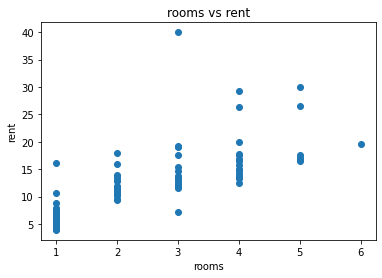

Correlation: 0.6929273993425428


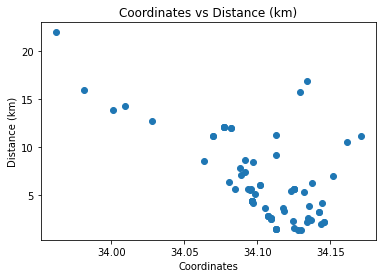

Correlation: -0.6143451255042779


In [ ]:
from scipy.stats import pearsonr
# since there are some rws that have an error in their coordinates, but they are not a majority, we are going to remove these to 
# be able to do a pearson correlation
df_study = df[df.Coordinates != 'Error']

# for encoding strings into numbers
def encoding(col,df):
    df_study = df
    encoding = lambda i:dict(enumerate(set(list(df_study[i]))))
    encoding = {v:k for k,v in encoding(col).items()}
    return [encoding[i] for i in df_study[col]]


encoding_coord = lambda col:[np.mean(i) for i in df_study[col]]

# investigate the correlations the different features have with each other

def feature_correlations(df_study,plot=True):
    checked,columns,correlations = [],list(df_study.columns),{k:[] for k in df_study.columns}

    for i in range(len(df_study.columns)):
        for j in range(len(df_study.columns)):
            if i != j and i != 0:
                if j not in checked:
                    
                    # print(columns[i],'vs',columns[j])                
                    
                    x,y = list(df_study[columns[i]]),list(df_study[columns[j]])
                    if type(x[0]) == str:
                        x = encoding(columns[i],df=df_study)
                    if type(y[0]) == str:
                        y = encoding(columns[j],df=df_study)                    
                    if type(x[0]) == tuple:
                        x = encoding_coord(columns[i])
                    if type(y[0]) == tuple:
                        y = encoding_coord(columns[j])                                        

                    correlation_coefficient, p_value = pearsonr(x, y)
                    
                    # add to dictionary to have the corrleations of the features with each other in a dic
                    correlations[columns[i]].append({columns[j]:correlation_coefficient})
                    
                    if plot:
                        if correlation_coefficient >= 0.5 or correlation_coefficient <= -0.5:
                            plt.scatter(x,y)
                            plt.xlabel(columns[i])
                            plt.ylabel(columns[j])
                            plt.title('{} vs {}'.format(columns[i],columns[j]))
                            plt.show()
                            print('Correlation:',correlation_coefficient)

            checked.append(i)
    return correlations

correlations = feature_correlations(df_study,plot=True)

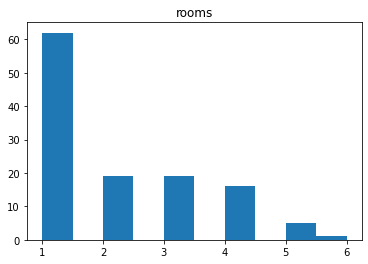

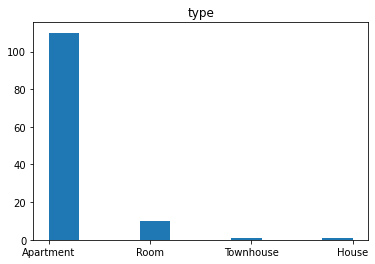

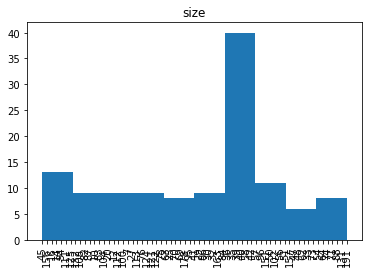

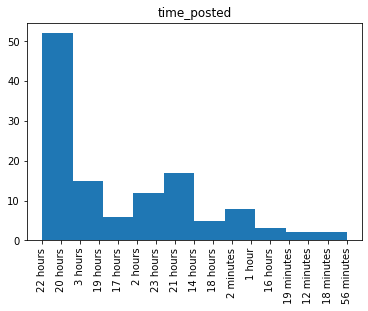

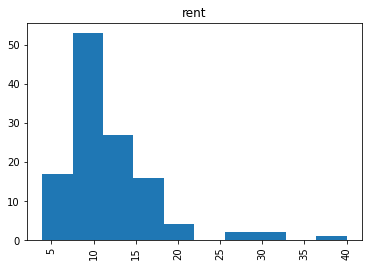

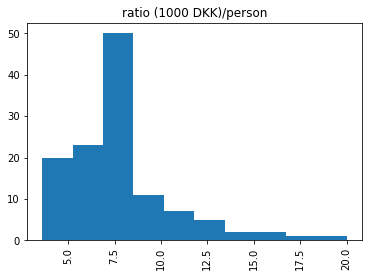

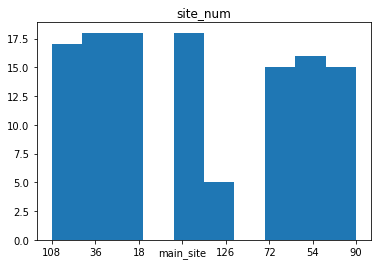

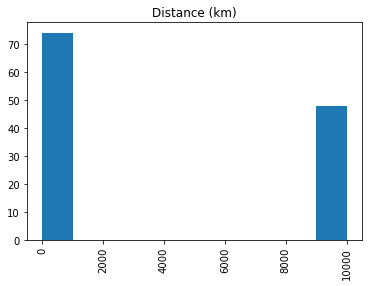

In [ ]:
def feature_distributions():
    c = ['rooms','type','size','time_posted','rent','ratio (1000 DKK)/person','site_num','Distance (km)']
    for i in c:    
        try:
            plt.hist(df[i])
            plt.title(i)
            if len(set(list(df[i]))) > 15:
                plt.xticks(rotation=90)        
            plt.show()

        except:
            l = [x for x in df[i] if not isinstance(x,str)]
            plt.hist(l)
            plt.title(i)
            plt.show()        
feature_distributions()            

This can be used to find the webapge of a place. All all the details of the url can be found in the dataset. All I need is the id of the location. This is where I iterate through all possible numbers until i find the right one. To ru all the functions you jsut have to run the last function :)

In [ ]:
# make a dictionary with all the required information for the url. All you must do i give the row index as an argument
def url_arguments_dic(df,n=0):
    row = n
    url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
    if df.iloc[row].type == 'Apartment':
        url_dic['type'] = 'apartments'
    elif df.iloc[row].type == 'Room':
        url_dic['type'] = 'rooms'
    url_dic['size'] = df.iloc[row]['size']
    url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
    url_dic['id'] = int(df.iloc[row]['id'])
    return url_dic


# now out the two functions together in this one to get the info from the page
def apartments_extra_info_extraction(df,n=0):
    d = url_arguments_dic(df=df,n=n)
    print(d)
    url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
    print(url)
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")    
    sharable = soup.find_all('div',class_='css-h1x6rg')

    info = {}
    for i in sharable:
        try:
            info_type = i.find_all('span',class_='css-arxwps')[0].text
            info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
            info[info_type] = info_answ
        except: pass    
    return info

# to run all the functions above all you have to do is run this one. There is no need to touch anything else
extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
extra_info_dic

{'type': 'apartments', 'size': '150', 'n_rooms': 4, 'id': 5363395}
https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/150m2-4-room-id-5363395


{'Property type': 'Apartment',
 'Size': '150 m²',
 'Rooms': '4',
 'Floor': '1st ',
 'Furnished': 'No',
 'Shareable': 'No',
 'Pets allowed': 'No',
 'Elevator': 'No',
 'Senior friendly': 'No',
 'Students only': 'No',
 'Balcony': 'No',
 'Parking': 'No',
 'Energy rating': '-',
 'Rental period': '1-11 months',
 'Available from': 'As soon as possible',
 'Monthly net rent': '10.455 kr.',
 'Utilities': '1.200 kr.',
 'Deposit': '30.000 kr.',
 'Prepaid rent': '0 kr.',
 'Move-in price': '41.655 kr.',
 'Creation Date': '04/06/2023',
 'Listing-id': '5363395'}